# Importing Python modules

In [77]:
import numpy as np
import pywt
from scipy import signal

%matplotlib inline
import matplotlib.pyplot as plt

 # ECG Signal

In [78]:
ch = 1

In [79]:

dispTime = 5
fs = 360

In [80]:
data = np.loadtxt('mit_arrythmia/100.txt',dtype = int)[:,ch]
print "Loaded ECG Signal CH #",ch
print "Samples Count : ", data.shape[0]
print "File Loaded"

Loaded ECG Signal CH # 1
Samples Count :  650000
File Loaded


In [81]:
def printSecSamples(data,start,end,t):
    print "Sample Count in the first " + str(end - start ) + " second(s) ", data[(t >= start ) & (t <= end)].shape[0] 

In [82]:
t1 = np.linspace(0,1.* data.shape[0] / fs, data.shape[0])
printSecSamples(data,0,5,t1);


Sample Count in the first 5 second(s)  1800


# Doing Wavelet Transform on ECG Signal for Compression

In [83]:
def applyWaveletTransform(data,wavelet,cascadeFactor):
    cA = data
    for i in range(cascadeFactor):
        cA,cD = pywt.dwt(cA,wavelet)
    return cA

In [84]:
def compressEcgSignal(sig,t,cascadeFactor):
    
    print "ECG Signal # of Samples: ", sig.shape[0]
    
    compressedSignal = applyWaveletTransform(sig,'db1',cascadeFactor)
    tNew = np.linspace(0, t[-1] , compressedSignal.shape[0])
    
    print "Compressed ECG Signal # of Samples (Cascading Factor : " + str(cascadeFactor) + ")", compressedSignal.shape[0]
   
    printSecSamples(compressedSignal,0,5,tNew)
    
    return compressedSignal, tNew



In [85]:
cascade = 1
ecgSignalC1, t2 = compressEcgSignal(x,t1,cascade)

print "------------------------------"

cascade += 1
ecgSignalC2, t3 =compressEcgSignal(x,t1,cascade)



ECG Signal # of Samples:  650000
Compressed ECG Signal # of Samples (Cascading Factor : 1) 325000
Sample Count in the first 5 second(s)  900
------------------------------
ECG Signal # of Samples:  650000
Compressed ECG Signal # of Samples (Cascading Factor : 2) 162500
Sample Count in the first 5 second(s)  450


In [86]:
def displayEcgSignal(t,sig,xMin,xMax,title):
    plt.figure( figsize = (16,3))
    plt.plot(t,sig)
    plt.xlim(xMin,xMax)
    
    ymin = np.amin(sig[(t >= xMin) & (t <= xMax)], axis = 0)
    ymax = np.amax(sig[(t >= xMin) & (t <= xMax)], axis = 0)
    
    plt.ylim(ymin - 50 ,ymax + 50)
    plt.grid()
    plt.title(title)
    plt.show()

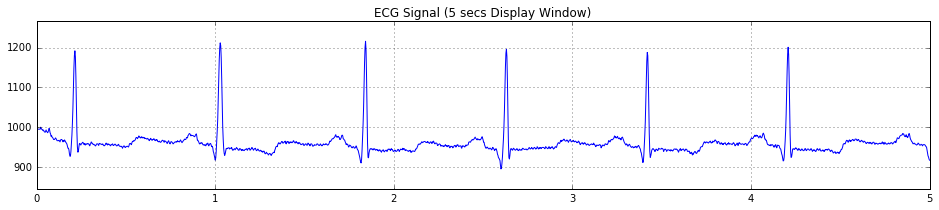

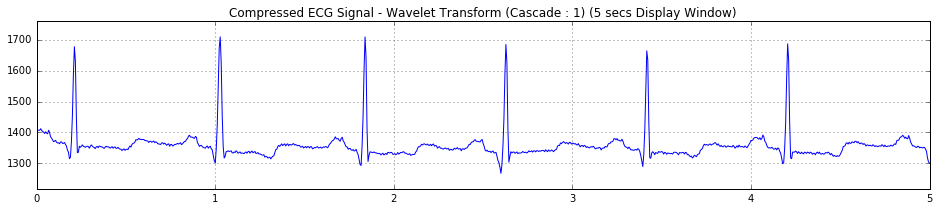

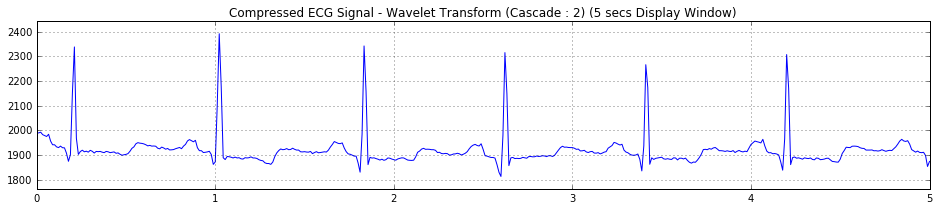

In [87]:

# Display Original ECG Signal
title1 = "ECG Signal (" + str(dispTime) + " secs Display Window)"
displayEcgSignal(t1,data,0,dispTime,title1)

# Display Compressed ECG Signal (C1)
title2 = "Compressed ECG Signal - Wavelet Transform (Cascade : 1) (" + str(dispTime) + " secs Display Window)"
displayEcgSignal(t2,ecgSignalC1,0,dispTime,title2)

# Display Compressed ECG Signal (C2)
title3 = "Compressed ECG Signal - Wavelet Transform (Cascade : 2) (" + str(dispTime) + " secs Display Window)"
displayEcgSignal(t3,ecgSignalC2,0,dispTime,title3)


In [98]:
def sGolayFilter(sig):
    k = 3
    f = 1201
    trend = signal.savgol_filter(sig,f,k)
    fSig = sig - trend
    return fSig

In [89]:
def displayEcgSignal2(t,sig,title):
    
    plt.figure( figsize = (16,3))
    plt.plot(t,sig)
    
    ymin = np.amin(sig, axis = 0)
    ymax = np.amax(sig, axis = 0)
    
    plt.ylim(ymin - 20 ,ymax + 20)
    plt.grid()
    plt.title(title)
   
    line = np.zeros(int(t.shape[0]))
    plt.plot(t,line,'r')
    plt.show()
    
    

In [91]:
winSec = 5;
ecgSignal = data[(t1 >=0) & (t1<= winSec)]
t = t1[0:ecgSignal.shape[0]:1]
print "ECG Signal Subset done"

ECG Signal Subset done


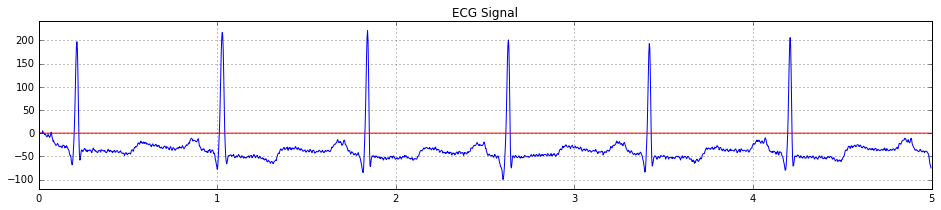

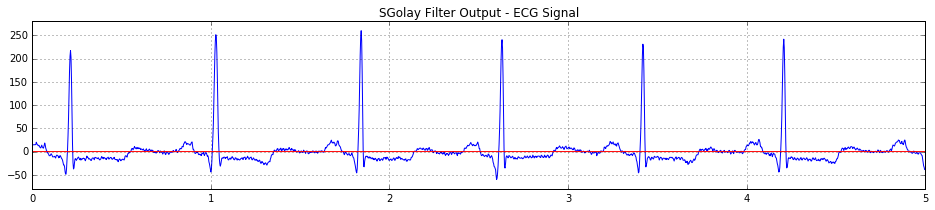

In [99]:
ecgSignal = ecgSignal - ecgSignal[0]
displayEcgSignal2(t,ecgSignal,"ECG Signal")

fEcgSignal = sGolayFilter(ecgSignal)
displayEcgSignal2(t,fEcgSignal,"SGolay Filter Output - ECG Signal")